In [1]:
bodensee_area = [48.00, 8.54, 47.29, 10.17] # Bodensee
europe_area= [60., -11., 34., 35.] # Europe

In [2]:
# CDS API helper

import cdsapi
import hashlib
import os

cds_data_dir = "data/cds"
temp_dir = "data/temp"

# You'll have to provide an API key for the CDS api.
# You can set this in a global configuration file, like described in the cdsapi documentation.
# Alternatively, set it right here in the notebook
cds_url = "https://cds.climate.copernicus.eu/api/v2"
cds_key = None
# cds_key = "000000:aaaaaaaa-bbbb-cccc-9999-0123456789ab"

class CDS_Dataset():
    '''
    Thin wrapper around CDS Python API for caching datasets locally.
    '''
    
    def __init__(self, topic, config):
        self.topic = topic
        self.config = config

    def path(self):
        h = hashlib.new('SHA256')
        h.update(self.topic.encode('utf-8'))
        for k, v in sorted(self.config.items()):
            h.update(f'|{k}:{v}'.encode('utf-8'))
        fingerprint = h.hexdigest()[:16]
        return f"{cds_data_dir}/dataset_{fingerprint}.{self.config["format"]}"

    def retrieve(self):
        os.makedirs(cds_data_dir, exist_ok=True)
        if cds_key is not None:
            cdsc = cdsapi.Client(url = cds_url, key = cds_key)
        else:
            cdsc = cdsapi.Client()
        cdsc.retrieve(self.topic, self.config, self.path())

    def is_local(self):
        return os.path.exists(self.path())

    def load(self):
        if not self.is_local():
            self.retrieve()

        return self.path()

# CDS_dataset usage example

dataset = CDS_Dataset(
    'satellite-lake-water-temperature', {
        'variable': 'all',
        'format': 'zip',
        'version': '4.5.2',
        'year': '2022',
        'month': [ f"{x:02d}" for x in range(1, 13) ],
        'day': [ f"{x:02d}" for x in range(1, 32) ],
        'area': bodensee_area
    })

dataset.load()

'data/cds/dataset_39f356db72d96f20.zip'

In [3]:
# Lake Water Surface Temperature
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-lake-water-temperature

import shutil
import tempfile
import xarray
import zipfile

class SatelliteLakeWaterTemperature():
    '''
    Wrapper for CDS Python API simplifing access to the satellite-lake-water-temperatur dataset.
    '''
    
    def __init__(self, area, years):
        self.topic = 'satellite-lake-water-temperature'
        self.area = area
        self.years = years
        self.nc_dir = None

    def cds_dataset_year(self, year):
        config = dict(
            variable = 'all',
            format = 'zip',
            version = '4.5.1' if year <= 2020 else '4.5.2',
            year = year,
            month = [ f"{x:02d}" for x in range(1, 13) ],
            day = [ f"{x:02d}" for x in range(1, 32) ],
            area = self.area,
        )
        return CDS_Dataset(self.topic, config)

    def load(self):
        datasets = [ self.cds_dataset_year(y) for y in self.years ]
        local = sum([d.is_local() for d in datasets])
        print(f"{local}/{len(datasets)} datasets are available locally")
        if local < len(datasets):
            print("get remaining datasets from CDS ...")
        return [ d.load() for d in datasets ]

    def xarray(self):
        if self.nc_dir is None:
            self.nc_dir = tempfile.mkdtemp(prefix="cds-" + self.topic + "-")
            
            for path in self.load():  
                with zipfile.ZipFile(path,"r") as f:
                    f.extractall(self.nc_dir)

        nc_files = [ e.path for e in os.scandir(self.nc_dir) if e.path.endswith(".nc") ]
        nc_files = sorted(nc_files)
        return xarray.open_mfdataset(nc_files)

    def free(self):
        if self.nc_dir is not None:
            shutil.rmtree(self.nc_dir)
        

    def __del__(self):
        # self.free()
        pass

# SatelliteLakeWaterTemperature usage example
# it should work  for`years = range(1995, 2024)` but downloading 27 datasets will take some time!

d = SatelliteLakeWaterTemperature(bodensee_area, years = range(2021, 2024)).xarray()
d

3/3 datasets are available locally


<xarray.Dataset> Size: 18MB
Dimensions:                         (time: 1095, lat: 14, lon: 32)
Coordinates:
  * lat                             (lat) float32 56B 47.33 47.38 ... 47.97
  * lon                             (lon) float32 128B 8.575 8.625 ... 10.12
  * time                            (time) datetime64[ns] 9kB 2021-01-01T12:0...
Data variables:
    lake_surface_water_temperature  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_uncertainty                (time, lat, lon) float32 2MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_quality_level              (time, lat, lon) float32 2MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_obs_instr                  (time, lat, lon) float32 2MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lswt_flag_bias_correction       (time, lat, lon) float32 2MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lakeid_CCI                      (time, lat, lon) float64 4MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
    lakeid_GloboLakes               (time, lat, lon) float64 4MB dask.array<chunksize=(1, 14, 32), meta=np.ndarray>
Attributes: (12/51)
    title:                           UK Earth Observation Climate Information...
    institution:                     EOCIS, University of Reading
    summary:                         L3S product from the ESA CCI project: LS...
    citation:                        Carrea, L., Crétaux, J.-F., Liu, X., Wu,...
    licence:                         Creative Commons Attribution 4.0 Interna...
    reference:                       https://cds.climate.copernicus.eu
    ...                              ...
    easternmost_longitude:           180.0
    westernmost_longitude:           -180.0
    processing_level:                L3S
    cdm_data_type:                   grid
    source_file:                     20210101120000-ESACCI-L3C_GHRSST-SLSTRA-...
    source_file_path:                /gws/nopw/j04/nceo_uor/users/lcarrea01/O...

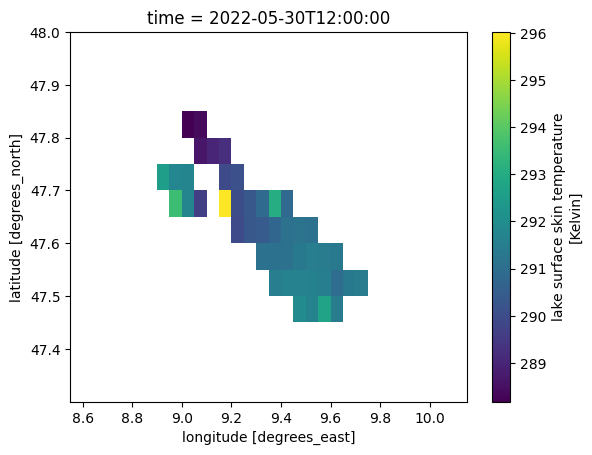

/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [4]:
d.sel(time='2022-05-30T12:00')['lake_surface_water_temperature'].plot()

/home/patrik/devel/sgc-cds-examples/venv/lib64/python3.12/site-packages/xarray/plot/utils.py:245: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


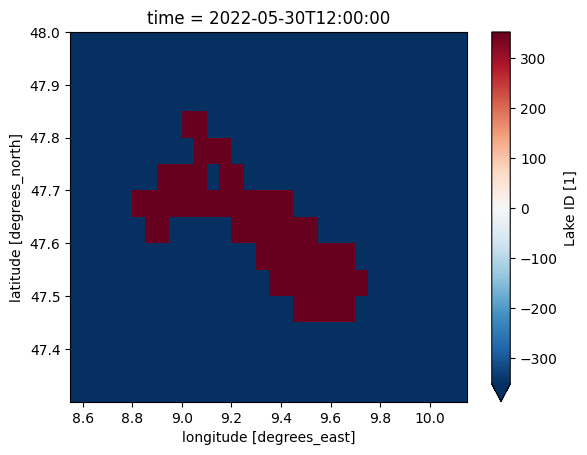

In [5]:
d.sel(time='2022-05-30T12:00')['lakeid_CCI'].astype('int').plot()

In [6]:
# CCI lake ids
# Source: https://zenodo.org/records/6699376

import pandas

cci_lakes_url = "https://zenodo.org/records/6699376/files/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021.csv?download=1"
cci_lakes = pandas.read_csv(cci_lakes_url).set_index('CCI ID')

# Bodensee has id 352
bodensee = 352
cci_lakes.loc[bodensee]

NAME                              Constance lake/Bodensee
COUNTRY                       Austria;Switzerland;Germany
MAX DISTANCE TO LAND (KM)                             6.0
LAT CENTRE                                        47.5431
LON CENTRE                                         9.5097
LAT MIN BOX                                       47.4375
LAT MAX BOX                                       47.8542
LON MIN BOX                                        8.7958
LON MAX BOX                                        9.7875
ID in GLOBOLAKES 1000 MASK                           352;
ID in CGLOPS MASK                                    352;
Name: 352, dtype: object

In [7]:
# subset the dataset; restrict to lake = Bodensee
ds = d.where(d['lakeid_CCI'] == float(bodensee))

In [8]:
# derive time series for mean surface temperature
ts = ds['lake_surface_water_temperature'].groupby('time').mean(['lat', 'lon'])
ts

<xarray.DataArray 'lake_surface_water_temperature' (time: 1095)> Size: 4kB
dask.array<stack, shape=(1095,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 9kB 2021-01-01T12:00:00 ... 2023-12-31T12:...
Attributes:
    units:                Kelvin
    long_name:            lake surface skin temperature
    valid_min:            -200
    valid_max:            5000
    comment:              The observations from different instruments have be...
    ancillary_variables:  lswt_uncertainty lswt_quality_level lswt_obs_instr ...

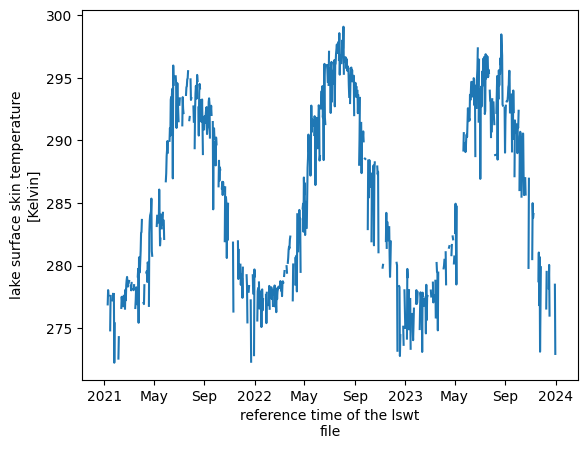

In [9]:
ts.plot()

In [10]:
import pandas
df = ts.to_pandas().to_frame()
df.columns = ['kelvin']
df['celsius'] = df['kelvin'] - 273.15
df['lakeid'] = bodensee
df['lake'] = 'Bodensee'
df

,kelvin,celsius,lakeid,lake
time,,,,
2021-01-01 12:00:00,275.325562,2.175568,352,Bodensee
2021-01-02 12:00:00,NaN,NaN,352,Bodensee
2021-01-03 12:00:00,NaN,NaN,352,Bodensee
2021-01-04 12:00:00,NaN,NaN,352,Bodensee
2021-01-05 12:00:00,NaN,NaN,352,Bodensee
...,...,...,...,...
2023-12-27 12:00:00,278.067078,4.917084,352,Bodensee
2023-12-28 12:00:00,NaN,NaN,352,Bodensee
2023-12-29 12:00:00,NaN,NaN,352,Bodensee


<Axes: xlabel='time'>

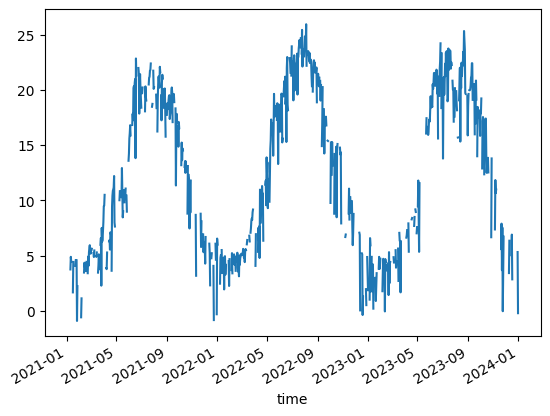

In [11]:
df['celsius'].plot()